# Intercomparison Campaigns - Interpolate Data

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the usability of data from intercomparison campaigns.

    Author: U. Voggenberger
    Date: 09.2020
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2020

In [1]:
import pandas
import numpy as np
import datetime
import glob
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cdsapi, zipfile, os, time

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (10,10)
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

## Accessing data :

We will interpolate pressure data to compare different sondes, which were all mounted onto the same balloon. <br>
It's not necessary to select the data with the help of 'ListProfiles.xls' - a file for mapping the data of the different sondes to one ascent. <br>
Opening all available data and searching for the matching report_id would be possible too, we want to show you that it's not necessary to load all the data before computing. <br> <br>


__Consider that there is no height information matching the pressure values on early radiosondes.__ <br> <br>


We will select a reference sonde, based on the longest series of measurements.<br>
The pressure data of our reference sonde will be interpolated onto the time - minutes since the ascent start.<br>
With the resulting interpolation funktion we can get the exact moment, when the sonde were on a standard pressure level.<br>
In the second step we will get the pressure value of all the other sondes to that given time. For this process it's necessary to interpolate backwards: time onto pressure.<br>


2020-10-21 10:19:39,964 INFO Welcome to the CDS
2020-10-21 10:19:39,965 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


1956-5-27T9.0:30.0


2020-10-21 10:19:40,232 INFO Request is queued
2020-10-21 10:19:41,266 INFO Request is running
2020-10-21 10:19:42,800 INFO Request is completed
2020-10-21 10:19:42,800 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:19:42,883 INFO Download rate 154K/s


Unzipping retrieved files: to ./exampla_data/5/0


2020-10-21 10:19:43,132 INFO Welcome to the CDS
2020-10-21 10:19:43,132 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:19:43,212 INFO Request is queued


0-20100-0-00401-000


2020-10-21 10:19:44,245 INFO Request is running
2020-10-21 10:19:45,779 INFO Request is completed
2020-10-21 10:19:45,839 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:19:45,894 INFO Download rate 271.5K/s


Unzipping retrieved files: to ./exampla_data/5/1


2020-10-21 10:19:46,170 INFO Welcome to the CDS
2020-10-21 10:19:46,171 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:19:46,242 INFO Request is queued


0-20100-0-00402-000


2020-10-21 10:19:47,275 INFO Request is running
2020-10-21 10:19:48,810 INFO Request is completed
2020-10-21 10:19:49,169 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:19:49,225 INFO Download rate 222.9K/s
2020-10-21 10:19:49,331 INFO Welcome to the CDS
2020-10-21 10:19:49,331 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:19:49,391 INFO Request is queued


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00403-000


2020-10-21 10:19:50,424 INFO Request is running
2020-10-21 10:19:51,958 INFO Request is completed
2020-10-21 10:19:52,012 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:19:52,098 INFO Download rate 152.1K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00404-000


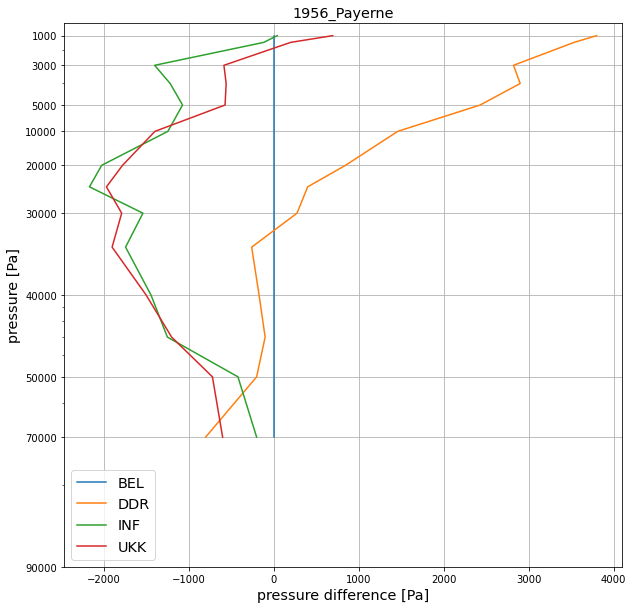

2020-10-21 10:19:52,718 INFO Welcome to the CDS
2020-10-21 10:19:52,718 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:19:52,782 INFO Request is queued


1956-5-27T15.0:0.0


2020-10-21 10:19:53,817 INFO Request is running
2020-10-21 10:19:55,351 INFO Request is completed
2020-10-21 10:19:55,351 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:19:55,384 INFO Download rate 311.6K/s
2020-10-21 10:19:55,438 INFO Welcome to the CDS
2020-10-21 10:19:55,438 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:19:55,564 INFO Request is queued


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00405-001


2020-10-21 10:19:56,596 INFO Request is running
2020-10-21 10:19:58,130 INFO Request is completed
2020-10-21 10:19:58,170 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:19:58,225 INFO Download rate 285.5K/s
2020-10-21 10:19:58,292 INFO Welcome to the CDS
2020-10-21 10:19:58,293 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:19:58,406 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00406-001


2020-10-21 10:19:58,436 INFO Download rate 412K/s
2020-10-21 10:19:58,475 INFO Welcome to the CDS
2020-10-21 10:19:58,475 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:19:58,545 INFO Request is queued


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00403-001


2020-10-21 10:19:59,579 INFO Request is running
2020-10-21 10:20:01,114 INFO Request is completed
2020-10-21 10:20:01,152 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:01,209 INFO Download rate 240.2K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00407-001


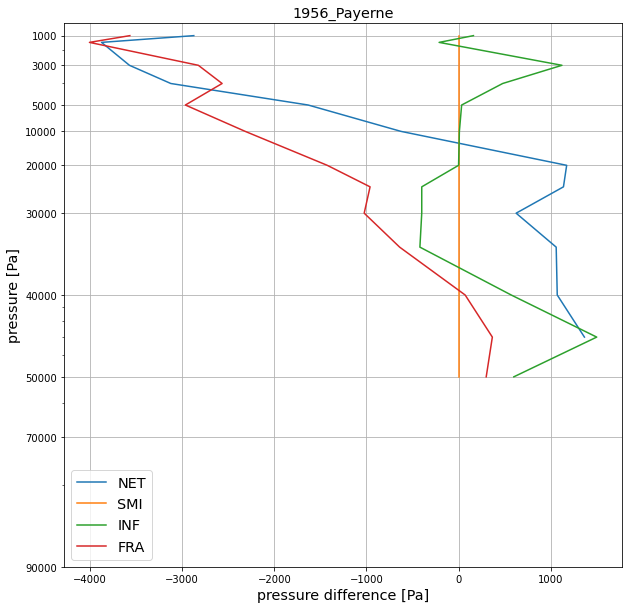

2020-10-21 10:20:01,655 INFO Welcome to the CDS
2020-10-21 10:20:01,655 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:01,775 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
  0%|          | 0.00/12.7k [00:00<?, ?B/s]

1956-5-28T9.0:0.0


2020-10-21 10:20:01,831 INFO Download rate 232K/s
2020-10-21 10:20:01,882 INFO Welcome to the CDS
2020-10-21 10:20:01,883 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:01,945 INFO Request is queued


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-002


2020-10-21 10:20:02,979 INFO Request is running
2020-10-21 10:20:04,513 INFO Request is completed
2020-10-21 10:20:04,572 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:04,627 INFO Download rate 341.5K/s
2020-10-21 10:20:04,704 INFO Welcome to the CDS
2020-10-21 10:20:04,705 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:04,764 INFO Request is queued


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00408-002


2020-10-21 10:20:05,798 INFO Request is running
2020-10-21 10:20:07,332 INFO Request is completed
2020-10-21 10:20:07,374 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:20:07,433 INFO Download rate 276.5K/s
2020-10-21 10:20:07,519 INFO Welcome to the CDS
2020-10-21 10:20:07,520 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00409-002


2020-10-21 10:20:07,670 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:07,700 INFO Download rate 335.2K/s
2020-10-21 10:20:07,754 INFO Welcome to the CDS
2020-10-21 10:20:07,754 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00405-002
1956-5-28T15.0:0.0


2020-10-21 10:20:07,929 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:07,984 INFO Download rate 343.1K/s
2020-10-21 10:20:08,051 INFO Welcome to the CDS
2020-10-21 10:20:08,051 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00408-003


2020-10-21 10:20:08,263 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:08,319 INFO Download rate 271.8K/s
2020-10-21 10:20:08,357 INFO Welcome to the CDS
2020-10-21 10:20:08,358 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:08,419 INFO Request is queued


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00402-003


2020-10-21 10:20:09,454 INFO Request is running
2020-10-21 10:20:10,990 INFO Request is completed
2020-10-21 10:20:11,030 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:11,085 INFO Download rate 249.3K/s
2020-10-21 10:20:11,127 INFO Welcome to the CDS
2020-10-21 10:20:11,128 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:11,252 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:11,283 INFO Download rate 515.8K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00410-003
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:11,379 INFO Welcome to the CDS
2020-10-21 10:20:11,380 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:11,455 INFO Request is queued


0-20100-0-00406-003
1956-5-28T22.0:0.0


2020-10-21 10:20:12,489 INFO Request is running
2020-10-21 10:20:14,023 INFO Request is completed
2020-10-21 10:20:14,061 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:14,091 INFO Download rate 363.6K/s
2020-10-21 10:20:14,150 INFO Welcome to the CDS
2020-10-21 10:20:14,150 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00411-004


2020-10-21 10:20:14,432 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:14,489 INFO Download rate 231.4K/s
2020-10-21 10:20:14,548 INFO Welcome to the CDS
2020-10-21 10:20:14,549 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00404-004


2020-10-21 10:20:14,739 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:14,794 INFO Download rate 224.7K/s
2020-10-21 10:20:14,833 INFO Welcome to the CDS
2020-10-21 10:20:14,834 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:14,978 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00403-004


2020-10-21 10:20:15,008 INFO Download rate 451.2K/s
2020-10-21 10:20:15,095 INFO Welcome to the CDS
2020-10-21 10:20:15,096 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00407-004
1956-5-29T0.0:30.0


2020-10-21 10:20:15,382 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:15,438 INFO Download rate 234.9K/s
2020-10-21 10:20:15,492 INFO Welcome to the CDS
2020-10-21 10:20:15,492 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:15,638 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00404-005


2020-10-21 10:20:15,669 INFO Download rate 335.5K/s
2020-10-21 10:20:15,711 INFO Welcome to the CDS
2020-10-21 10:20:15,711 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:15,833 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:15,863 INFO Download rate 426.8K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00405-005
Unzipping retrieved files: to ./exampla_data/5/2


2020-10-21 10:20:15,922 INFO Welcome to the CDS
2020-10-21 10:20:15,923 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:15,981 INFO Request is queued


0-20100-0-00401-005


2020-10-21 10:20:17,016 INFO Request is running
2020-10-21 10:20:18,550 INFO Request is completed
2020-10-21 10:20:18,678 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:18,733 INFO Download rate 252.7K/s
2020-10-21 10:20:18,790 INFO Welcome to the CDS
2020-10-21 10:20:18,791 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:18,911 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-005
1956-5-29T9.0:0.0


2020-10-21 10:20:18,941 INFO Download rate 501K/s
2020-10-21 10:20:19,003 INFO Welcome to the CDS
2020-10-21 10:20:19,004 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00402-006


2020-10-21 10:20:19,300 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:20:19,357 INFO Download rate 291.8K/s
2020-10-21 10:20:19,396 INFO Welcome to the CDS
2020-10-21 10:20:19,397 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:19,495 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:19,549 INFO Download rate 249.1K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00409-006
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-006


2020-10-21 10:20:19,591 INFO Welcome to the CDS
2020-10-21 10:20:19,591 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:19,649 INFO Request is queued
2020-10-21 10:20:20,683 INFO Request is running
2020-10-21 10:20:22,218 INFO Request is completed
2020-10-21 10:20:22,256 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:22,312 INFO Download rate 257.4K/s
2020-10-21 10:20:22,357 INFO Welcome to the CDS
2020-10-21 10:20:22,357 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:22,478 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-3

Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00413-006
1956-5-29T15.0:0.0


2020-10-21 10:20:22,534 INFO Download rate 292.1K/s
2020-10-21 10:20:22,573 INFO Welcome to the CDS
2020-10-21 10:20:22,573 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00409-007


2020-10-21 10:20:22,783 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:22,838 INFO Download rate 249.8K/s
2020-10-21 10:20:22,924 INFO Welcome to the CDS
2020-10-21 10:20:22,924 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:23,029 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00410-007


2020-10-21 10:20:23,061 INFO Download rate 451.2K/s
2020-10-21 10:20:23,101 INFO Welcome to the CDS
2020-10-21 10:20:23,102 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:23,202 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:23,232 INFO Download rate 404.5K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00412-007
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:23,298 INFO Welcome to the CDS
2020-10-21 10:20:23,299 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:23,400 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:23,431 INFO Download rate 334K/s


0-20100-0-00403-007
1956-5-29T22.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00405-008


2020-10-21 10:20:23,472 INFO Welcome to the CDS
2020-10-21 10:20:23,472 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:23,572 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:23,603 INFO Download rate 521.4K/s
2020-10-21 10:20:23,641 INFO Welcome to the CDS
2020-10-21 10:20:23,641 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:23,748 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:23,779 INFO Download rate 620.6K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00406-008
Unzipping retrieved files: to ./exampla_data/5/2


2020-10-21 10:20:23,848 INFO Welcome to the CDS
2020-10-21 10:20:23,848 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:23,946 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:23,976 INFO Download rate 367.9K/s


0-20100-0-00408-008
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:24,064 INFO Welcome to the CDS
2020-10-21 10:20:24,064 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:24,207 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)


0-20100-0-00411-008
1956-5-30T0.0:30.0


2020-10-21 10:20:24,237 INFO Download rate 520.8K/s
2020-10-21 10:20:24,278 INFO Welcome to the CDS
2020-10-21 10:20:24,279 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:24,403 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:24,433 INFO Download rate 476.8K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-009
Unzipping retrieved files: to ./exampla_data/5/1


2020-10-21 10:20:24,484 INFO Welcome to the CDS
2020-10-21 10:20:24,485 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:24,651 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)


0-20100-0-00413-009


2020-10-21 10:20:24,683 INFO Download rate 482.4K/s
2020-10-21 10:20:24,763 INFO Welcome to the CDS
2020-10-21 10:20:24,764 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00402-009


2020-10-21 10:20:24,909 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:24,965 INFO Download rate 234.5K/s
2020-10-21 10:20:25,036 INFO Welcome to the CDS
2020-10-21 10:20:25,037 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:25,154 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00404-009
1956-5-30T9.0:0.0


2020-10-21 10:20:25,208 INFO Download rate 252.6K/s
2020-10-21 10:20:25,247 INFO Welcome to the CDS
2020-10-21 10:20:25,248 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:25,349 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:25,380 INFO Download rate 447.6K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00410-010
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00407-010


2020-10-21 10:20:25,440 INFO Welcome to the CDS
2020-10-21 10:20:25,441 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:25,575 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:25,606 INFO Download rate 364.4K/s
2020-10-21 10:20:25,642 INFO Welcome to the CDS
2020-10-21 10:20:25,642 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:25,743 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:25,773 INFO Download rate 424K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00411-010
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00401-010
1956-5-30T15.0:0.0


2020-10-21 10:20:25,824 INFO Welcome to the CDS
2020-10-21 10:20:25,825 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:25,940 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:25,971 INFO Download rate 453.4K/s
2020-10-21 10:20:26,025 INFO Welcome to the CDS
2020-10-21 10:20:26,025 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:26,123 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:26,154 INFO Download rate 457.5K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00407-011
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00412-011


2020-10-21 10:20:26,198 INFO Welcome to the CDS
2020-10-21 10:20:26,199 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:26,299 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:26,355 INFO Download rate 235.8K/s
2020-10-21 10:20:26,393 INFO Welcome to the CDS
2020-10-21 10:20:26,393 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:26,490 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:26,545 INFO Download rate 342.2K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00404-011
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:26,607 INFO Welcome to the CDS
2020-10-21 10:20:26,607 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:26,709 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:26,740 INFO Download rate 475.5K/s


0-20100-0-00408-011
1956-5-30T22.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00413-012


2020-10-21 10:20:26,792 INFO Welcome to the CDS
2020-10-21 10:20:26,793 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:26,889 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:26,920 INFO Download rate 410.1K/s
2020-10-21 10:20:26,968 INFO Welcome to the CDS
2020-10-21 10:20:26,969 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00403-012


2020-10-21 10:20:27,143 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:20:27,199 INFO Download rate 289.8K/s
2020-10-21 10:20:27,254 INFO Welcome to the CDS
2020-10-21 10:20:27,254 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:27,353 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:27,383 INFO Download rate 337.7K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00409-012
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:27,468 INFO Welcome to the CDS
2020-10-21 10:20:27,468 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:27,584 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
  0%|          | 0.00/12.3k [00:00<?, ?B/s]

0-20100-0-00405-012
1956-5-31T0.0:30.0


2020-10-21 10:20:27,640 INFO Download rate 220.5K/s
2020-10-21 10:20:27,692 INFO Welcome to the CDS
2020-10-21 10:20:27,693 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:27,815 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00403-013


2020-10-21 10:20:27,846 INFO Download rate 422K/s
2020-10-21 10:20:27,898 INFO Welcome to the CDS
2020-10-21 10:20:27,898 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:27,997 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:28,029 INFO Download rate 429.3K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00401-013
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00410-013


2020-10-21 10:20:28,071 INFO Welcome to the CDS
2020-10-21 10:20:28,072 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:28,259 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:28,314 INFO Download rate 284.5K/s
2020-10-21 10:20:28,375 INFO Welcome to the CDS
2020-10-21 10:20:28,376 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:28,477 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:28,508 INFO Download rate 458.1K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00406-013
1956-5-31T9.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0


2020-10-21 10:20:28,565 INFO Welcome to the CDS
2020-10-21 10:20:28,565 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:28,701 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:28,732 INFO Download rate 359.6K/s


0-20100-0-00412-014
Unzipping retrieved files: to ./exampla_data/5/1


2020-10-21 10:20:28,773 INFO Welcome to the CDS
2020-10-21 10:20:28,773 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


0-20100-0-00411-014


2020-10-21 10:20:28,992 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:29,023 INFO Download rate 333.7K/s
2020-10-21 10:20:29,061 INFO Welcome to the CDS
2020-10-21 10:20:29,061 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:29,166 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:29,197 INFO Download rate 483.1K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00405-014
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00402-014
1956-5-31T15.0:0.0


2020-10-21 10:20:29,253 INFO Welcome to the CDS
2020-10-21 10:20:29,254 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:29,364 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:29,395 INFO Download rate 358.4K/s
2020-10-21 10:20:29,437 INFO Welcome to the CDS
2020-10-21 10:20:29,437 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:29,561 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
  0%|          | 0.00/13.1k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00411-015


2020-10-21 10:20:29,617 INFO Download rate 234.9K/s
2020-10-21 10:20:29,668 INFO Welcome to the CDS
2020-10-21 10:20:29,668 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:29,770 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:29,801 INFO Download rate 509.3K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00404-015
Unzipping retrieved files: to ./exampla_data/5/2


2020-10-21 10:20:29,859 INFO Welcome to the CDS
2020-10-21 10:20:29,859 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:29,959 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:20:30,016 INFO Download rate 287.9K/s


0-20100-0-00406-015
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:30,070 INFO Welcome to the CDS
2020-10-21 10:20:30,071 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:30,179 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:30,210 INFO Download rate 414.8K/s


0-20100-0-00409-015
1956-5-31T22.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-016


2020-10-21 10:20:30,248 INFO Welcome to the CDS
2020-10-21 10:20:30,248 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:30,407 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:30,462 INFO Download rate 342K/s
2020-10-21 10:20:30,503 INFO Welcome to the CDS
2020-10-21 10:20:30,504 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:30,607 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:30,638 INFO Download rate 445.3K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00408-016
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-016


2020-10-21 10:20:30,679 INFO Welcome to the CDS
2020-10-21 10:20:30,680 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:30,781 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:30,812 INFO Download rate 464.9K/s
2020-10-21 10:20:30,857 INFO Welcome to the CDS
2020-10-21 10:20:30,857 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:31,008 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00413-016
1956-6-1T0.0:30.0


2020-10-21 10:20:31,064 INFO Download rate 341.6K/s
2020-10-21 10:20:31,103 INFO Welcome to the CDS
2020-10-21 10:20:31,104 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:31,216 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:31,246 INFO Download rate 496.6K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00408-017
Unzipping retrieved files: to ./exampla_data/5/1


2020-10-21 10:20:31,299 INFO Welcome to the CDS
2020-10-21 10:20:31,299 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:31,410 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:31,441 INFO Download rate 455.4K/s


0-20100-0-00402-017
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00412-017


2020-10-21 10:20:31,482 INFO Welcome to the CDS
2020-10-21 10:20:31,483 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:31,585 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:31,615 INFO Download rate 406.7K/s
2020-10-21 10:20:31,678 INFO Welcome to the CDS
2020-10-21 10:20:31,678 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:31,779 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
  0%|          | 0.00/13.1k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00403-017
1956-6-1T9.0:0.0


2020-10-21 10:20:31,836 INFO Download rate 235.5K/s
2020-10-21 10:20:31,887 INFO Welcome to the CDS
2020-10-21 10:20:31,887 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:32,000 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:32,031 INFO Download rate 331.1K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00404-018
Unzipping retrieved files: to ./exampla_data/5/1


2020-10-21 10:20:32,072 INFO Welcome to the CDS
2020-10-21 10:20:32,072 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:32,172 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:32,203 INFO Download rate 470.7K/s
2020-10-21 10:20:32,242 INFO Welcome to the CDS
2020-10-21 10:20:32,242 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


0-20100-0-00405-018
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00413-018


2020-10-21 10:20:32,342 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:32,373 INFO Download rate 454.4K/s
2020-10-21 10:20:32,421 INFO Welcome to the CDS
2020-10-21 10:20:32,422 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:32,559 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00410-018
1956-6-1T15.0:0.0


2020-10-21 10:20:32,590 INFO Download rate 327.9K/s
2020-10-21 10:20:32,632 INFO Welcome to the CDS
2020-10-21 10:20:32,632 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00405-019


2020-10-21 10:20:32,866 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:32,897 INFO Download rate 511.3K/s
2020-10-21 10:20:32,938 INFO Welcome to the CDS
2020-10-21 10:20:32,938 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:33,044 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:33,074 INFO Download rate 407.7K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00406-019
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00403-019


2020-10-21 10:20:33,113 INFO Welcome to the CDS
2020-10-21 10:20:33,114 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:33,220 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:33,251 INFO Download rate 449.8K/s
2020-10-21 10:20:33,294 INFO Welcome to the CDS
2020-10-21 10:20:33,295 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:33,449 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00407-019
1956-6-1T22.0:0.0


2020-10-21 10:20:33,480 INFO Download rate 490.8K/s
2020-10-21 10:20:33,523 INFO Welcome to the CDS
2020-10-21 10:20:33,523 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:33,631 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
  0%|          | 0.00/16.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00402-020


2020-10-21 10:20:33,688 INFO Download rate 284.3K/s
2020-10-21 10:20:33,728 INFO Welcome to the CDS
2020-10-21 10:20:33,729 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:33,832 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:33,863 INFO Download rate 363.1K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00409-020
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00411-020


2020-10-21 10:20:33,898 INFO Welcome to the CDS
2020-10-21 10:20:33,899 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:34,012 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:34,043 INFO Download rate 419.7K/s
2020-10-21 10:20:34,091 INFO Welcome to the CDS
2020-10-21 10:20:34,091 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:34,195 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
  0%|          | 0.00/16.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00401-020
1956-6-2T0.0:30.0


2020-10-21 10:20:34,251 INFO Download rate 290.3K/s
2020-10-21 10:20:34,291 INFO Welcome to the CDS
2020-10-21 10:20:34,291 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00409-021


2020-10-21 10:20:34,480 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:34,536 INFO Download rate 249.9K/s
2020-10-21 10:20:34,595 INFO Welcome to the CDS
2020-10-21 10:20:34,595 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00410-021


2020-10-21 10:20:34,771 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:34,827 INFO Download rate 234.1K/s
2020-10-21 10:20:34,865 INFO Welcome to the CDS
2020-10-21 10:20:34,866 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:34,997 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
  0%|          | 0.00/18.7k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00404-021


2020-10-21 10:20:35,054 INFO Download rate 336K/s
2020-10-21 10:20:35,113 INFO Welcome to the CDS
2020-10-21 10:20:35,114 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:35,231 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00408-021
1959-6-2T15.0:0.0


2020-10-21 10:20:35,262 INFO Download rate 622.3K/s
2020-10-21 10:20:35,301 INFO Welcome to the CDS
2020-10-21 10:20:35,301 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:35,401 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:35,432 INFO Download rate 491.6K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00408-022
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00402-022


2020-10-21 10:20:35,471 INFO Welcome to the CDS
2020-10-21 10:20:35,471 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:35,574 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:35,605 INFO Download rate 448.8K/s
2020-10-21 10:20:35,648 INFO Welcome to the CDS
2020-10-21 10:20:35,648 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00410-022


2020-10-21 10:20:35,831 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:35,862 INFO Download rate 518.4K/s
2020-10-21 10:20:35,910 INFO Welcome to the CDS
2020-10-21 10:20:35,910 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:36,023 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:36,053 INFO Download rate 478.5K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00406-022
1956-6-4T0.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00413-023


2020-10-21 10:20:36,093 INFO Welcome to the CDS
2020-10-21 10:20:36,093 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:36,215 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:36,245 INFO Download rate 413.6K/s
2020-10-21 10:20:36,305 INFO Welcome to the CDS
2020-10-21 10:20:36,305 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:36,414 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
  0%|          | 0.00/16.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00403-023


2020-10-21 10:20:36,471 INFO Download rate 285.5K/s
2020-10-21 10:20:36,512 INFO Welcome to the CDS
2020-10-21 10:20:36,512 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:36,622 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:36,653 INFO Download rate 338.9K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00409-023
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00405-023
1956-6-4T9.0:0.0


2020-10-21 10:20:36,699 INFO Welcome to the CDS
2020-10-21 10:20:36,699 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:36,872 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:36,927 INFO Download rate 286.7K/s
2020-10-21 10:20:36,974 INFO Welcome to the CDS
2020-10-21 10:20:36,974 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:37,094 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:37,126 INFO Download rate 456.3K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-024
Unzipping retrieved files: to ./exampla_data/5/1


2020-10-21 10:20:37,164 INFO Welcome to the CDS
2020-10-21 10:20:37,165 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:37,276 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:37,307 INFO Download rate 421.7K/s


0-20100-0-00413-024
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00401-024


2020-10-21 10:20:37,347 INFO Welcome to the CDS
2020-10-21 10:20:37,347 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:37,502 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:37,533 INFO Download rate 456K/s
2020-10-21 10:20:37,581 INFO Welcome to the CDS
2020-10-21 10:20:37,581 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:37,697 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:37,728 INFO Download rate 469.9K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-024
1956-6-4T15.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0


2020-10-21 10:20:37,768 INFO Welcome to the CDS
2020-10-21 10:20:37,768 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:37,893 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:37,924 INFO Download rate 402.4K/s


0-20100-0-00413-025
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00403-025


2020-10-21 10:20:37,961 INFO Welcome to the CDS
2020-10-21 10:20:37,961 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:38,095 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:38,126 INFO Download rate 598.3K/s
2020-10-21 10:20:38,166 INFO Welcome to the CDS
2020-10-21 10:20:38,166 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00408-025


2020-10-21 10:20:38,444 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:38,474 INFO Download rate 364.9K/s
2020-10-21 10:20:38,518 INFO Welcome to the CDS
2020-10-21 10:20:38,518 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:38,631 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:38,662 INFO Download rate 445.3K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00411-025
1956-6-4T22.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00410-026


2020-10-21 10:20:38,702 INFO Welcome to the CDS
2020-10-21 10:20:38,702 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:38,854 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:38,884 INFO Download rate 450.6K/s
2020-10-21 10:20:38,925 INFO Welcome to the CDS
2020-10-21 10:20:38,926 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:39,043 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:39,073 INFO Download rate 336.1K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00407-026
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00405-026


2020-10-21 10:20:39,110 INFO Welcome to the CDS
2020-10-21 10:20:39,110 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:39,226 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:39,256 INFO Download rate 498K/s
2020-10-21 10:20:39,311 INFO Welcome to the CDS
2020-10-21 10:20:39,311 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00402-026
1956-6-5T0.0:30.0


2020-10-21 10:20:39,493 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:39,524 INFO Download rate 442.5K/s
2020-10-21 10:20:39,569 INFO Welcome to the CDS
2020-10-21 10:20:39,569 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:39,677 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:39,707 INFO Download rate 462.1K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00407-027
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00412-027


2020-10-21 10:20:39,750 INFO Welcome to the CDS
2020-10-21 10:20:39,750 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:39,889 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:39,920 INFO Download rate 510.2K/s
2020-10-21 10:20:39,963 INFO Welcome to the CDS
2020-10-21 10:20:39,963 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:40,096 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00406-027


2020-10-21 10:20:40,152 INFO Download rate 290.7K/s
2020-10-21 10:20:40,212 INFO Welcome to the CDS
2020-10-21 10:20:40,213 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:40,326 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00409-027
1956-6-5T9.0:0.0


2020-10-21 10:20:40,357 INFO Download rate 408.8K/s
2020-10-21 10:20:40,395 INFO Welcome to the CDS
2020-10-21 10:20:40,395 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:40,500 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:40,530 INFO Download rate 424.1K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00403-028
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00401-028


2020-10-21 10:20:40,568 INFO Welcome to the CDS
2020-10-21 10:20:40,569 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:40,788 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:40,843 INFO Download rate 272.8K/s
2020-10-21 10:20:40,886 INFO Welcome to the CDS
2020-10-21 10:20:40,887 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:41,011 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
  0%|          | 0.00/13.1k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00402-028


2020-10-21 10:20:41,067 INFO Download rate 234.6K/s
2020-10-21 10:20:41,118 INFO Welcome to the CDS
2020-10-21 10:20:41,119 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:41,187 INFO Request is queued


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00404-028


2020-10-21 10:20:42,220 INFO Request is running
2020-10-21 10:20:43,754 INFO Request is completed
2020-10-21 10:20:43,819 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:20:43,851 INFO Download rate 316.9K/s
2020-10-21 10:20:44,000 INFO Welcome to the CDS
2020-10-21 10:20:44,001 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00414-028
1956-6-5T15.0:0.0


2020-10-21 10:20:44,109 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:44,164 INFO Download rate 232.1K/s
2020-10-21 10:20:44,202 INFO Welcome to the CDS
2020-10-21 10:20:44,202 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:44,308 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:44,339 INFO Download rate 613.4K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-029
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00408-029


2020-10-21 10:20:44,383 INFO Welcome to the CDS
2020-10-21 10:20:44,383 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:44,484 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:20:44,540 INFO Download rate 289.7K/s
2020-10-21 10:20:44,581 INFO Welcome to the CDS
2020-10-21 10:20:44,581 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:44,699 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00409-029


2020-10-21 10:20:44,755 INFO Download rate 180.4K/s
2020-10-21 10:20:44,819 INFO Welcome to the CDS
2020-10-21 10:20:44,819 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:44,941 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00405-029
1956-6-5T22.0:0.0


2020-10-21 10:20:44,972 INFO Download rate 456.7K/s
2020-10-21 10:20:45,028 INFO Welcome to the CDS
2020-10-21 10:20:45,028 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00412-030


2020-10-21 10:20:45,199 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:45,230 INFO Download rate 362.8K/s
2020-10-21 10:20:45,289 INFO Welcome to the CDS
2020-10-21 10:20:45,289 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:45,396 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:45,427 INFO Download rate 469.5K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-030
Unzipping retrieved files: to ./exampla_data/5/2


2020-10-21 10:20:45,466 INFO Welcome to the CDS
2020-10-21 10:20:45,466 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


0-20100-0-00413-030


2020-10-21 10:20:45,653 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:45,683 INFO Download rate 454.1K/s
2020-10-21 10:20:45,729 INFO Welcome to the CDS
2020-10-21 10:20:45,729 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:45,840 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:45,871 INFO Download rate 360.3K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00410-030
1956-6-6T0.0:30.0
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00411-031


2020-10-21 10:20:45,914 INFO Welcome to the CDS
2020-10-21 10:20:45,915 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:46,025 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:46,081 INFO Download rate 234.1K/s
2020-10-21 10:20:46,134 INFO Welcome to the CDS
2020-10-21 10:20:46,134 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:46,243 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:46,273 INFO Download rate 409.6K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00404-031
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00403-031


2020-10-21 10:20:46,312 INFO Welcome to the CDS
2020-10-21 10:20:46,313 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:46,496 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:46,552 INFO Download rate 246.2K/s
2020-10-21 10:20:46,598 INFO Welcome to the CDS
2020-10-21 10:20:46,598 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:46,731 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00407-031
1956-6-6T9.0:0.0


2020-10-21 10:20:46,762 INFO Download rate 624.2K/s
2020-10-21 10:20:46,801 INFO Welcome to the CDS
2020-10-21 10:20:46,801 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:46,904 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:46,934 INFO Download rate 501.3K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00408-032
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00402-032


2020-10-21 10:20:46,973 INFO Welcome to the CDS
2020-10-21 10:20:46,973 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:47,088 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:47,119 INFO Download rate 457.8K/s
2020-10-21 10:20:47,160 INFO Welcome to the CDS
2020-10-21 10:20:47,161 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:47,306 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00410-032


2020-10-21 10:20:47,336 INFO Download rate 524.3K/s
2020-10-21 10:20:47,377 INFO Welcome to the CDS
2020-10-21 10:20:47,378 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:47,484 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:20:47,515 INFO Download rate 321.7K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00406-032
Unzipping retrieved files: to ./exampla_data/5/4


2020-10-21 10:20:47,575 INFO Welcome to the CDS
2020-10-21 10:20:47,576 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:47,700 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:47,731 INFO Download rate 493.8K/s


0-20100-0-00414-032
1956-6-6T15.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0


2020-10-21 10:20:47,775 INFO Welcome to the CDS
2020-10-21 10:20:47,775 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:47,882 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:20:47,938 INFO Download rate 289.9K/s


0-20100-0-00402-033
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00409-033


2020-10-21 10:20:47,979 INFO Welcome to the CDS
2020-10-21 10:20:47,979 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:48,083 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:48,114 INFO Download rate 449.1K/s
2020-10-21 10:20:48,156 INFO Welcome to the CDS
2020-10-21 10:20:48,157 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:48,268 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:48,298 INFO Download rate 474.3K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-033
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00413-033


2020-10-21 10:20:48,339 INFO Welcome to the CDS
2020-10-21 10:20:48,340 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:48,456 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:20:48,488 INFO Download rate 321.2K/s
2020-10-21 10:20:48,536 INFO Welcome to the CDS
2020-10-21 10:20:48,537 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:48,656 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:48,688 INFO Download rate 424.2K/s


Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00414-033
1956-6-6T22.0:0.0


2020-10-21 10:20:48,741 INFO Welcome to the CDS
2020-10-21 10:20:48,742 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:48,845 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:48,877 INFO Download rate 328.3K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00404-034
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00405-034


2020-10-21 10:20:48,913 INFO Welcome to the CDS
2020-10-21 10:20:48,913 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:49,015 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:49,046 INFO Download rate 417.9K/s
2020-10-21 10:20:49,086 INFO Welcome to the CDS
2020-10-21 10:20:49,087 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:49,197 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:49,227 INFO Download rate 461.5K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00401-034
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:49,293 INFO Welcome to the CDS
2020-10-21 10:20:49,293 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:49,402 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:49,433 INFO Download rate 336.5K/s


0-20100-0-00412-034
1956-6-7T0.0:30.0
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00405-035


2020-10-21 10:20:49,473 INFO Welcome to the CDS
2020-10-21 10:20:49,474 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:49,579 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:49,610 INFO Download rate 513.6K/s
2020-10-21 10:20:49,662 INFO Welcome to the CDS
2020-10-21 10:20:49,662 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:49,777 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:49,809 INFO Download rate 602.6K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00406-035
Unzipping retrieved files: to ./exampla_data/5/2


2020-10-21 10:20:49,849 INFO Welcome to the CDS
2020-10-21 10:20:49,850 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:49,950 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:49,980 INFO Download rate 366.1K/s


0-20100-0-00408-035
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00411-035
1956-6-7T9.0:0.0


2020-10-21 10:20:50,022 INFO Welcome to the CDS
2020-10-21 10:20:50,022 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:50,141 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:20:50,197 INFO Download rate 291.4K/s
2020-10-21 10:20:50,235 INFO Welcome to the CDS
2020-10-21 10:20:50,236 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:50,347 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:50,378 INFO Download rate 455.4K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00409-036
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00410-036


2020-10-21 10:20:50,418 INFO Welcome to the CDS
2020-10-21 10:20:50,419 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:50,525 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:50,556 INFO Download rate 460.3K/s
2020-10-21 10:20:50,595 INFO Welcome to the CDS
2020-10-21 10:20:50,595 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:50,707 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:50,737 INFO Download rate 407.2K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00412-036
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00403-036


2020-10-21 10:20:50,774 INFO Welcome to the CDS
2020-10-21 10:20:50,774 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:50,883 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:50,914 INFO Download rate 618.9K/s
2020-10-21 10:20:50,960 INFO Welcome to the CDS
2020-10-21 10:20:50,961 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00408-036
1956-6-7T15.0:0.0


2020-10-21 10:20:51,195 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:51,226 INFO Download rate 453.8K/s
2020-10-21 10:20:51,266 INFO Welcome to the CDS
2020-10-21 10:20:51,266 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:51,411 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00410-037


2020-10-21 10:20:51,442 INFO Download rate 447.2K/s
2020-10-21 10:20:51,480 INFO Welcome to the CDS
2020-10-21 10:20:51,480 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:51,623 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00407-037


2020-10-21 10:20:51,654 INFO Download rate 613.6K/s
2020-10-21 10:20:51,694 INFO Welcome to the CDS
2020-10-21 10:20:51,694 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:51,820 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:51,850 INFO Download rate 362.4K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00408-037
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:51,886 INFO Welcome to the CDS
2020-10-21 10:20:51,887 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:51,997 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:52,030 INFO Download rate 397.5K/s


0-20100-0-00411-037
Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00401-037
1956-6-7T22.0:0.0


2020-10-21 10:20:52,079 INFO Welcome to the CDS
2020-10-21 10:20:52,080 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:52,303 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:20:52,334 INFO Download rate 511.1K/s
2020-10-21 10:20:52,377 INFO Welcome to the CDS
2020-10-21 10:20:52,378 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:52,489 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:52,519 INFO Download rate 472.7K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-038
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00413-038


2020-10-21 10:20:52,558 INFO Welcome to the CDS
2020-10-21 10:20:52,558 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:52,665 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:52,696 INFO Download rate 494.8K/s
2020-10-21 10:20:52,739 INFO Welcome to the CDS
2020-10-21 10:20:52,740 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00402-038


2020-10-21 10:20:52,920 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:52,976 INFO Download rate 235.3K/s
2020-10-21 10:20:53,028 INFO Welcome to the CDS
2020-10-21 10:20:53,028 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:53,131 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
  0%|          | 0.00/14.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00404-038
1956-6-8T0.0:30.0


2020-10-21 10:20:53,186 INFO Download rate 261.3K/s
2020-10-21 10:20:53,228 INFO Welcome to the CDS
2020-10-21 10:20:53,228 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:53,335 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:20:53,366 INFO Download rate 407K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00413-039
Unzipping retrieved files: to ./exampla_data/5/1


2020-10-21 10:20:53,456 INFO Welcome to the CDS
2020-10-21 10:20:53,457 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:53,575 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
  0%|          | 0.00/16.2k [00:00<?, ?B/s]

0-20100-0-00403-039


2020-10-21 10:20:53,631 INFO Download rate 289.7K/s
2020-10-21 10:20:53,681 INFO Welcome to the CDS
2020-10-21 10:20:53,681 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:53,786 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:53,817 INFO Download rate 332.9K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00409-039
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00405-039
1956-6-8T9.0:0.0


2020-10-21 10:20:53,856 INFO Welcome to the CDS
2020-10-21 10:20:53,856 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:53,956 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:53,987 INFO Download rate 445.3K/s
2020-10-21 10:20:54,028 INFO Welcome to the CDS
2020-10-21 10:20:54,029 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00407-040


2020-10-21 10:20:54,224 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:54,255 INFO Download rate 453.8K/s
2020-10-21 10:20:54,300 INFO Welcome to the CDS
2020-10-21 10:20:54,300 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:54,410 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
  0%|          | 0.00/13.1k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00412-040


2020-10-21 10:20:54,466 INFO Download rate 234.4K/s
2020-10-21 10:20:54,505 INFO Welcome to the CDS
2020-10-21 10:20:54,505 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:54,609 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:20:54,664 INFO Download rate 343K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00404-040
Unzipping retrieved files: to ./exampla_data/5/3


2020-10-21 10:20:54,713 INFO Welcome to the CDS
2020-10-21 10:20:54,713 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:54,823 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:20:54,854 INFO Download rate 458.8K/s


0-20100-0-00408-040
1956-6-8T15.0:0.0
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00412-041


2020-10-21 10:20:54,894 INFO Welcome to the CDS
2020-10-21 10:20:54,895 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:55,002 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:55,033 INFO Download rate 362.6K/s
2020-10-21 10:20:55,073 INFO Welcome to the CDS
2020-10-21 10:20:55,073 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:55,199 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:20:55,230 INFO Download rate 336.2K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-041
Unzipping retrieved files: to ./exampla_data/5/2


2020-10-21 10:20:55,267 INFO Welcome to the CDS
2020-10-21 10:20:55,268 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:55,390 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:55,421 INFO Download rate 487.2K/s


0-20100-0-00405-041
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00402-041


2020-10-21 10:20:55,464 INFO Welcome to the CDS
2020-10-21 10:20:55,465 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:55,577 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:20:55,633 INFO Download rate 289.2K/s
2020-10-21 10:20:55,672 INFO Welcome to the CDS
2020-10-21 10:20:55,672 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:55,794 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
  0%|          | 0.00/18.7k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00409-041


2020-10-21 10:20:55,850 INFO Download rate 341.5K/s
2020-10-21 10:20:55,985 INFO Welcome to the CDS
2020-10-21 10:20:55,985 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00408-041
1956-6-8T22.0:0.0


2020-10-21 10:20:56,094 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:20:56,124 INFO Download rate 472.8K/s
2020-10-21 10:20:56,163 INFO Welcome to the CDS
2020-10-21 10:20:56,164 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:56,265 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:56,296 INFO Download rate 494.5K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00413-042
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00402-042


2020-10-21 10:20:56,336 INFO Welcome to the CDS
2020-10-21 10:20:56,336 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:56,457 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:56,487 INFO Download rate 365.5K/s
2020-10-21 10:20:56,526 INFO Welcome to the CDS
2020-10-21 10:20:56,526 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:56,659 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
  0%|          | 0.00/13.5k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00411-042


2020-10-21 10:20:56,690 INFO Download rate 443.2K/s
2020-10-21 10:20:56,758 INFO Welcome to the CDS
2020-10-21 10:20:56,758 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:56,886 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00407-042


2020-10-21 10:20:56,941 INFO Download rate 286.4K/s
2020-10-21 10:20:56,984 INFO Welcome to the CDS
2020-10-21 10:20:56,985 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00406-042


2020-10-21 10:20:57,190 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:20:57,247 INFO Download rate 233.5K/s
2020-10-21 10:20:57,303 INFO Welcome to the CDS
2020-10-21 10:20:57,304 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:57,412 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
  0%|          | 0.00/12.3k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00404-042


2020-10-21 10:20:57,468 INFO Download rate 223.4K/s
2020-10-21 10:20:57,546 INFO Welcome to the CDS
2020-10-21 10:20:57,547 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:57,658 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00403-042


2020-10-21 10:20:57,714 INFO Download rate 289.9K/s


Unzipping retrieved files: to ./exampla_data/5/7


2020-10-21 10:20:58,036 INFO Welcome to the CDS
2020-10-21 10:20:58,037 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:58,153 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
  0%|          | 0.00/18.7k [00:00<?, ?B/s]

0-20100-0-00409-042


2020-10-21 10:20:58,208 INFO Download rate 342.5K/s


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00408-042
1956-6-9T9.0:0.0


2020-10-21 10:20:58,435 INFO Welcome to the CDS
2020-10-21 10:20:58,435 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:58,541 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:20:58,571 INFO Download rate 425.9K/s
2020-10-21 10:20:58,610 INFO Welcome to the CDS
2020-10-21 10:20:58,611 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:58,711 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:20:58,741 INFO Download rate 462.4K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-043
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00410-043


2020-10-21 10:20:58,779 INFO Welcome to the CDS
2020-10-21 10:20:58,780 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:58,885 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:20:58,916 INFO Download rate 488.5K/s
2020-10-21 10:20:58,957 INFO Welcome to the CDS
2020-10-21 10:20:58,957 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:59,078 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:20:59,109 INFO Download rate 367.8K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00402-043
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00411-043


2020-10-21 10:20:59,152 INFO Welcome to the CDS
2020-10-21 10:20:59,157 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:59,262 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:20:59,293 INFO Download rate 447.6K/s
2020-10-21 10:20:59,336 INFO Welcome to the CDS
2020-10-21 10:20:59,336 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:59,463 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
  0%|          | 0.00/14.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00407-043


2020-10-21 10:20:59,495 INFO Download rate 458K/s
2020-10-21 10:20:59,538 INFO Welcome to the CDS
2020-10-21 10:20:59,539 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:20:59,654 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
  0%|          | 0.00/16.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00413-043


2020-10-21 10:20:59,714 INFO Download rate 273K/s
2020-10-21 10:20:59,839 INFO Welcome to the CDS
2020-10-21 10:20:59,840 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00409-043


2020-10-21 10:20:59,952 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:21:00,007 INFO Download rate 343.4K/s
2020-10-21 10:21:00,084 INFO Welcome to the CDS
2020-10-21 10:21:00,085 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:00,195 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)


Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00408-043
1956-6-9T22.0:0.0


2020-10-21 10:21:00,225 INFO Download rate 494.4K/s
2020-10-21 10:21:00,266 INFO Welcome to the CDS
2020-10-21 10:21:00,266 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:00,396 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
                                           

Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00402-044


2020-10-21 10:21:00,427 INFO Download rate 359.8K/s
2020-10-21 10:21:00,484 INFO Welcome to the CDS
2020-10-21 10:21:00,484 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:00,621 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-044


2020-10-21 10:21:00,652 INFO Download rate 333.9K/s
2020-10-21 10:21:00,694 INFO Welcome to the CDS
2020-10-21 10:21:00,694 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:00,837 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00405-044


2020-10-21 10:21:00,870 INFO Download rate 439.8K/s
2020-10-21 10:21:00,911 INFO Welcome to the CDS
2020-10-21 10:21:00,911 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:01,018 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:01,049 INFO Download rate 405.9K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00413-044
Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00403-044


2020-10-21 10:21:01,086 INFO Welcome to the CDS
2020-10-21 10:21:01,087 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:01,190 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:21:01,221 INFO Download rate 418.2K/s
2020-10-21 10:21:01,264 INFO Welcome to the CDS
2020-10-21 10:21:01,265 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:01,372 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
  0%|          | 0.00/16.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00401-044


2020-10-21 10:21:01,429 INFO Download rate 287.8K/s
2020-10-21 10:21:01,469 INFO Welcome to the CDS
2020-10-21 10:21:01,470 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:01,581 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
  0%|          | 0.00/18.7k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00409-044


2020-10-21 10:21:01,636 INFO Download rate 343.3K/s
2020-10-21 10:21:01,689 INFO Welcome to the CDS
2020-10-21 10:21:01,689 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00408-044
1956-6-11Tnan:nan


2020-10-21 10:21:01,842 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:01,873 INFO Download rate 445.6K/s
2020-10-21 10:21:01,915 INFO Welcome to the CDS
2020-10-21 10:21:01,915 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:02,032 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:21:02,063 INFO Download rate 450K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00410-045
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00412-045


2020-10-21 10:21:02,108 INFO Welcome to the CDS
2020-10-21 10:21:02,109 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:02,217 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:21:02,274 INFO Download rate 234.9K/s
2020-10-21 10:21:02,316 INFO Welcome to the CDS
2020-10-21 10:21:02,317 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:02,425 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:21:02,456 INFO Download rate 334.4K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00404-045
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00405-045


2020-10-21 10:21:02,496 INFO Welcome to the CDS
2020-10-21 10:21:02,497 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:02,619 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:02,651 INFO Download rate 457.6K/s
2020-10-21 10:21:02,692 INFO Welcome to the CDS
2020-10-21 10:21:02,692 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:02,822 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
  0%|          | 0.00/12.3k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00413-045


2020-10-21 10:21:02,853 INFO Download rate 398.4K/s
2020-10-21 10:21:02,898 INFO Welcome to the CDS
2020-10-21 10:21:02,898 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:03,040 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)


Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00403-045


2020-10-21 10:21:03,097 INFO Download rate 283.6K/s
2020-10-21 10:21:03,137 INFO Welcome to the CDS
2020-10-21 10:21:03,138 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00409-045


2020-10-21 10:21:03,338 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:21:03,393 INFO Download rate 340.7K/s
2020-10-21 10:21:03,479 INFO Welcome to the CDS
2020-10-21 10:21:03,479 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00408-045
1956-6-11Tnan:nan


2020-10-21 10:21:03,602 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:21:03,633 INFO Download rate 409.5K/s
2020-10-21 10:21:03,673 INFO Welcome to the CDS
2020-10-21 10:21:03,674 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:03,815 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-046


2020-10-21 10:21:03,846 INFO Download rate 359.9K/s
2020-10-21 10:21:03,885 INFO Welcome to the CDS
2020-10-21 10:21:03,886 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:03,991 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:21:04,023 INFO Download rate 432.6K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-046
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-046


2020-10-21 10:21:04,065 INFO Welcome to the CDS
2020-10-21 10:21:04,065 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:04,170 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:21:04,201 INFO Download rate 453.8K/s
2020-10-21 10:21:04,241 INFO Welcome to the CDS
2020-10-21 10:21:04,242 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:04,350 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:04,381 INFO Download rate 477.1K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-046
Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00402-046


2020-10-21 10:21:04,425 INFO Welcome to the CDS
2020-10-21 10:21:04,425 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:04,539 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:04,571 INFO Download rate 504.4K/s
2020-10-21 10:21:04,620 INFO Welcome to the CDS
2020-10-21 10:21:04,620 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:04,750 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)


Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00406-046


2020-10-21 10:21:04,781 INFO Download rate 327.7K/s
2020-10-21 10:21:04,822 INFO Welcome to the CDS
2020-10-21 10:21:04,822 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00405-046


2020-10-21 10:21:04,997 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:05,030 INFO Download rate 436.8K/s
2020-10-21 10:21:05,073 INFO Welcome to the CDS
2020-10-21 10:21:05,074 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:05,207 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)


Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00413-046


2020-10-21 10:21:05,264 INFO Download rate 233.3K/s
2020-10-21 10:21:05,343 INFO Welcome to the CDS
2020-10-21 10:21:05,344 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00404-046


2020-10-21 10:21:05,481 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:05,536 INFO Download rate 223.9K/s
2020-10-21 10:21:05,602 INFO Welcome to the CDS
2020-10-21 10:21:05,602 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:05,719 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)


Unzipping retrieved files: to ./exampla_data/5/9
0-20100-0-00403-046


2020-10-21 10:21:05,750 INFO Download rate 450.3K/s
2020-10-21 10:21:05,849 INFO Welcome to the CDS
2020-10-21 10:21:05,849 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/10
0-20100-0-00410-046


2020-10-21 10:21:05,961 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:05,992 INFO Download rate 325K/s
2020-10-21 10:21:06,079 INFO Welcome to the CDS
2020-10-21 10:21:06,079 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:06,190 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)


Unzipping retrieved files: to ./exampla_data/5/11
0-20100-0-00414-046


2020-10-21 10:21:06,245 INFO Download rate 347.7K/s
2020-10-21 10:21:06,316 INFO Welcome to the CDS
2020-10-21 10:21:06,317 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:06,429 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)


Unzipping retrieved files: to ./exampla_data/5/12
0-20100-0-00408-046


2020-10-21 10:21:06,485 INFO Download rate 289.7K/s
2020-10-21 10:21:06,554 INFO Welcome to the CDS
2020-10-21 10:21:06,554 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:06,662 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)


Unzipping retrieved files: to ./exampla_data/5/13
0-20100-0-00409-046
1956-6-11Tnan:nan


2020-10-21 10:21:06,717 INFO Download rate 233.6K/s
2020-10-21 10:21:06,758 INFO Welcome to the CDS
2020-10-21 10:21:06,759 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:06,876 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:21:06,907 INFO Download rate 356.8K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-047
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-047


2020-10-21 10:21:06,946 INFO Welcome to the CDS
2020-10-21 10:21:06,947 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:07,138 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:21:07,193 INFO Download rate 248.5K/s
2020-10-21 10:21:07,235 INFO Welcome to the CDS
2020-10-21 10:21:07,235 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:07,365 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
  0%|          | 0.00/13.8k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-047


2020-10-21 10:21:07,396 INFO Download rate 456.6K/s
2020-10-21 10:21:07,434 INFO Welcome to the CDS
2020-10-21 10:21:07,434 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-047


2020-10-21 10:21:07,714 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:07,744 INFO Download rate 497.3K/s
2020-10-21 10:21:07,787 INFO Welcome to the CDS
2020-10-21 10:21:07,787 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:07,901 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:07,931 INFO Download rate 524.4K/s


Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00402-047
Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00406-047


2020-10-21 10:21:07,971 INFO Welcome to the CDS
2020-10-21 10:21:07,972 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:08,096 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:21:08,126 INFO Download rate 339.5K/s
2020-10-21 10:21:08,167 INFO Welcome to the CDS
2020-10-21 10:21:08,167 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:08,287 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:08,318 INFO Download rate 474.4K/s


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00405-047
Unzipping retrieved files: to ./exampla_data/5/7


2020-10-21 10:21:08,380 INFO Welcome to the CDS
2020-10-21 10:21:08,380 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:08,488 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:21:08,545 INFO Download rate 232.8K/s


0-20100-0-00413-047


2020-10-21 10:21:08,586 INFO Welcome to the CDS
2020-10-21 10:21:08,586 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:08,696 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:08,726 INFO Download rate 413.3K/s


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00404-047
Unzipping retrieved files: to ./exampla_data/5/9
0-20100-0-00403-047


2020-10-21 10:21:08,771 INFO Welcome to the CDS
2020-10-21 10:21:08,772 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:08,883 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:08,913 INFO Download rate 456.6K/s
2020-10-21 10:21:08,973 INFO Welcome to the CDS
2020-10-21 10:21:08,973 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:09,082 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:09,113 INFO Download rate 322.7K/s


Unzipping retrieved files: to ./exampla_data/5/10
0-20100-0-00410-047
Unzipping retrieved files: to ./exampla_data/5/11


2020-10-21 10:21:09,149 INFO Welcome to the CDS
2020-10-21 10:21:09,149 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:09,254 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:21:09,309 INFO Download rate 345.1K/s


0-20100-0-00414-047
Unzipping retrieved files: to ./exampla_data/5/12
0-20100-0-00408-047


2020-10-21 10:21:09,354 INFO Welcome to the CDS
2020-10-21 10:21:09,354 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:09,584 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:21:09,640 INFO Download rate 291.2K/s
2020-10-21 10:21:09,698 INFO Welcome to the CDS
2020-10-21 10:21:09,699 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:09,808 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
  0%|          | 0.00/14.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/13
0-20100-0-00409-047
1956-6-12Tnan:nan


2020-10-21 10:21:09,862 INFO Download rate 261.7K/s
2020-10-21 10:21:09,906 INFO Welcome to the CDS
2020-10-21 10:21:09,907 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:10,017 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:10,049 INFO Download rate 502.3K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00413-048
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00406-048


2020-10-21 10:21:10,090 INFO Welcome to the CDS
2020-10-21 10:21:10,091 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:10,202 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:10,234 INFO Download rate 483.5K/s
2020-10-21 10:21:10,279 INFO Welcome to the CDS
2020-10-21 10:21:10,279 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:10,387 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
  0%|          | 0.00/13.1k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00402-048


2020-10-21 10:21:10,443 INFO Download rate 234.8K/s
2020-10-21 10:21:10,486 INFO Welcome to the CDS
2020-10-21 10:21:10,487 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:10,612 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:21:10,643 INFO Download rate 423K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00404-048
1956-6-12Tnan:nan
Unzipping retrieved files: to ./exampla_data/5/0


2020-10-21 10:21:10,682 INFO Welcome to the CDS
2020-10-21 10:21:10,683 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:10,787 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:21:10,817 INFO Download rate 364.9K/s


0-20100-0-00401-049
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-049


2020-10-21 10:21:10,855 INFO Welcome to the CDS
2020-10-21 10:21:10,855 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:10,983 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:21:11,014 INFO Download rate 449.2K/s
2020-10-21 10:21:11,055 INFO Welcome to the CDS
2020-10-21 10:21:11,055 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:11,165 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-049


2020-10-21 10:21:11,248 INFO Download rate 169.6K/s
2020-10-21 10:21:11,288 INFO Welcome to the CDS
2020-10-21 10:21:11,289 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:11,399 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:11,430 INFO Download rate 482.1K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-049
Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00402-049


2020-10-21 10:21:11,475 INFO Welcome to the CDS
2020-10-21 10:21:11,475 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:11,586 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:11,617 INFO Download rate 508K/s
2020-10-21 10:21:11,661 INFO Welcome to the CDS
2020-10-21 10:21:11,661 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:11,771 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:21:11,802 INFO Download rate 334.7K/s


Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00406-049
Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00405-049


2020-10-21 10:21:11,843 INFO Welcome to the CDS
2020-10-21 10:21:11,844 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:11,984 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:12,015 INFO Download rate 469.7K/s
2020-10-21 10:21:12,060 INFO Welcome to the CDS
2020-10-21 10:21:12,060 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:12,168 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
  0%|          | 0.00/13.1k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00413-049


2020-10-21 10:21:12,225 INFO Download rate 233K/s
2020-10-21 10:21:12,265 INFO Welcome to the CDS
2020-10-21 10:21:12,266 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:12,370 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:12,400 INFO Download rate 408.7K/s


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00404-049
Unzipping retrieved files: to ./exampla_data/5/9
0-20100-0-00403-049


2020-10-21 10:21:12,438 INFO Welcome to the CDS
2020-10-21 10:21:12,439 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:12,539 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:12,569 INFO Download rate 456.5K/s
2020-10-21 10:21:12,611 INFO Welcome to the CDS
2020-10-21 10:21:12,612 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:12,719 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:12,750 INFO Download rate 324.9K/s


Unzipping retrieved files: to ./exampla_data/5/10
0-20100-0-00410-049
Unzipping retrieved files: to ./exampla_data/5/11
0-20100-0-00414-049


2020-10-21 10:21:12,791 INFO Welcome to the CDS
2020-10-21 10:21:12,792 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:12,916 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:21:12,948 INFO Download rate 518.3K/s
2020-10-21 10:21:12,999 INFO Welcome to the CDS
2020-10-21 10:21:12,999 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:13,117 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
  0%|          | 0.00/18.7k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/12
0-20100-0-00409-049


2020-10-21 10:21:13,174 INFO Download rate 335.6K/s
2020-10-21 10:21:13,237 INFO Welcome to the CDS
2020-10-21 10:21:13,237 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:13,357 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)


Unzipping retrieved files: to ./exampla_data/5/13
0-20100-0-00408-049
1956-6-12Tnan:nan


2020-10-21 10:21:13,388 INFO Download rate 452.2K/s
2020-10-21 10:21:13,451 INFO Welcome to the CDS
2020-10-21 10:21:13,452 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:13,575 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00412-050


2020-10-21 10:21:13,606 INFO Download rate 440.7K/s
2020-10-21 10:21:13,647 INFO Welcome to the CDS
2020-10-21 10:21:13,647 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00407-050


2020-10-21 10:21:13,855 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:21:13,886 INFO Download rate 359.4K/s
2020-10-21 10:21:13,929 INFO Welcome to the CDS
2020-10-21 10:21:13,930 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00411-050


2020-10-21 10:21:14,133 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:21:14,190 INFO Download rate 234K/s
2020-10-21 10:21:14,232 INFO Welcome to the CDS
2020-10-21 10:21:14,233 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:14,342 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
  0%|          | 0.00/14.2k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00404-050


2020-10-21 10:21:14,397 INFO Download rate 260.9K/s
2020-10-21 10:21:14,438 INFO Welcome to the CDS
2020-10-21 10:21:14,438 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:14,560 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:14,591 INFO Download rate 449.5K/s


Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00413-050
Unzipping retrieved files: to ./exampla_data/5/5


2020-10-21 10:21:14,637 INFO Welcome to the CDS
2020-10-21 10:21:14,638 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:14,763 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:14,794 INFO Download rate 402.4K/s


0-20100-0-00410-050
Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00403-050


2020-10-21 10:21:14,839 INFO Welcome to the CDS
2020-10-21 10:21:14,840 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:14,951 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:21:15,007 INFO Download rate 291.2K/s
2020-10-21 10:21:15,046 INFO Welcome to the CDS
2020-10-21 10:21:15,046 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:15,158 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
  0%|          | 0.00/18.7k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00409-050


2020-10-21 10:21:15,212 INFO Download rate 344.1K/s
2020-10-21 10:21:15,265 INFO Welcome to the CDS
2020-10-21 10:21:15,266 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:15,378 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:21:15,408 INFO Download rate 420.9K/s


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00408-050
1956-6-13Tnan:nan
Unzipping retrieved files: to ./exampla_data/5/0


2020-10-21 10:21:15,453 INFO Welcome to the CDS
2020-10-21 10:21:15,453 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


0-20100-0-00401-051


2020-10-21 10:21:15,644 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:21:15,675 INFO Download rate 361.9K/s
2020-10-21 10:21:15,717 INFO Welcome to the CDS
2020-10-21 10:21:15,718 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:15,847 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-051


2020-10-21 10:21:15,880 INFO Download rate 428.3K/s
2020-10-21 10:21:15,924 INFO Welcome to the CDS
2020-10-21 10:21:15,925 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:16,031 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:21:16,062 INFO Download rate 451.8K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-051
Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-051


2020-10-21 10:21:16,105 INFO Welcome to the CDS
2020-10-21 10:21:16,106 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:16,204 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:16,235 INFO Download rate 489.8K/s
2020-10-21 10:21:16,280 INFO Welcome to the CDS
2020-10-21 10:21:16,280 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:16,389 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:16,420 INFO Download rate 504.3K/s


Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00402-051
Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00406-051


2020-10-21 10:21:16,465 INFO Welcome to the CDS
2020-10-21 10:21:16,465 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:16,571 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:21:16,602 INFO Download rate 334.4K/s
2020-10-21 10:21:16,648 INFO Welcome to the CDS
2020-10-21 10:21:16,649 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:16,754 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:16,786 INFO Download rate 463.2K/s


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00405-051
Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00413-051


2020-10-21 10:21:16,838 INFO Welcome to the CDS
2020-10-21 10:21:16,838 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:16,985 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:21:17,042 INFO Download rate 235.1K/s
2020-10-21 10:21:17,128 INFO Welcome to the CDS
2020-10-21 10:21:17,128 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:17,234 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00404-051


2020-10-21 10:21:17,289 INFO Download rate 223.8K/s
2020-10-21 10:21:17,332 INFO Welcome to the CDS
2020-10-21 10:21:17,332 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/9
0-20100-0-00403-051


2020-10-21 10:21:17,614 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:17,670 INFO Download rate 249.1K/s
2020-10-21 10:21:17,728 INFO Welcome to the CDS
2020-10-21 10:21:17,729 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:17,856 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)


Unzipping retrieved files: to ./exampla_data/5/10
0-20100-0-00410-051


2020-10-21 10:21:17,887 INFO Download rate 321.3K/s
2020-10-21 10:21:17,930 INFO Welcome to the CDS
2020-10-21 10:21:17,930 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:18,038 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:21:18,069 INFO Download rate 526.3K/s


Unzipping retrieved files: to ./exampla_data/5/11
0-20100-0-00414-051
Unzipping retrieved files: to ./exampla_data/5/12
0-20100-0-00409-051


2020-10-21 10:21:18,107 INFO Welcome to the CDS
2020-10-21 10:21:18,107 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:18,237 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:21:18,292 INFO Download rate 344.5K/s
2020-10-21 10:21:18,349 INFO Welcome to the CDS
2020-10-21 10:21:18,350 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:18,481 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)


Unzipping retrieved files: to ./exampla_data/5/13
0-20100-0-00408-051
1956-6-13Tnan:nan


2020-10-21 10:21:18,512 INFO Download rate 414.7K/s
2020-10-21 10:21:18,553 INFO Welcome to the CDS
2020-10-21 10:21:18,554 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:18,679 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:21:18,710 INFO Download rate 361.3K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-052
Unzipping retrieved files: to ./exampla_data/5/1


2020-10-21 10:21:18,762 INFO Welcome to the CDS
2020-10-21 10:21:18,762 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:18,888 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:21:18,919 INFO Download rate 445.6K/s


0-20100-0-00411-052
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-052


2020-10-21 10:21:18,962 INFO Welcome to the CDS
2020-10-21 10:21:18,963 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:19,073 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:21:19,104 INFO Download rate 459.1K/s
2020-10-21 10:21:19,143 INFO Welcome to the CDS
2020-10-21 10:21:19,143 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:19,258 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:19,289 INFO Download rate 480.6K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-052
Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00402-052


2020-10-21 10:21:19,334 INFO Welcome to the CDS
2020-10-21 10:21:19,334 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:19,445 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:19,476 INFO Download rate 512.9K/s
2020-10-21 10:21:19,519 INFO Welcome to the CDS
2020-10-21 10:21:19,519 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00406-052


2020-10-21 10:21:19,686 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:21:19,716 INFO Download rate 333.6K/s
2020-10-21 10:21:19,760 INFO Welcome to the CDS
2020-10-21 10:21:19,761 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:19,870 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:19,900 INFO Download rate 473.2K/s


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00405-052
Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00413-052


2020-10-21 10:21:19,950 INFO Welcome to the CDS
2020-10-21 10:21:19,950 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:20,062 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:21:20,119 INFO Download rate 232.7K/s
2020-10-21 10:21:20,159 INFO Welcome to the CDS
2020-10-21 10:21:20,160 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00404-052


2020-10-21 10:21:20,328 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:20,383 INFO Download rate 224.3K/s
2020-10-21 10:21:20,423 INFO Welcome to the CDS
2020-10-21 10:21:20,424 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:20,533 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:20,564 INFO Download rate 449.6K/s


Unzipping retrieved files: to ./exampla_data/5/9
0-20100-0-00403-052
Unzipping retrieved files: to ./exampla_data/5/10


2020-10-21 10:21:20,619 INFO Welcome to the CDS
2020-10-21 10:21:20,620 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:20,729 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:20,761 INFO Download rate 318K/s


0-20100-0-00410-052
Unzipping retrieved files: to ./exampla_data/5/11
0-20100-0-00414-052


2020-10-21 10:21:20,818 INFO Welcome to the CDS
2020-10-21 10:21:20,819 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:20,925 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:21:20,956 INFO Download rate 516.7K/s
2020-10-21 10:21:20,995 INFO Welcome to the CDS
2020-10-21 10:21:20,995 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:21,096 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:21:21,152 INFO Download rate 339.8K/s


Unzipping retrieved files: to ./exampla_data/5/12
0-20100-0-00409-052
Unzipping retrieved files: to ./exampla_data/5/13


2020-10-21 10:21:21,290 INFO Welcome to the CDS
2020-10-21 10:21:21,290 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


0-20100-0-00408-052
1956-6-14Tnan:nan


2020-10-21 10:21:21,405 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
2020-10-21 10:21:21,437 INFO Download rate 411.7K/s
2020-10-21 10:21:21,477 INFO Welcome to the CDS
2020-10-21 10:21:21,478 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:21,633 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-053


2020-10-21 10:21:21,664 INFO Download rate 358.1K/s
2020-10-21 10:21:21,702 INFO Welcome to the CDS
2020-10-21 10:21:21,703 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-053


2020-10-21 10:21:21,895 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:21:21,951 INFO Download rate 244.1K/s
2020-10-21 10:21:21,992 INFO Welcome to the CDS
2020-10-21 10:21:21,993 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:22,128 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-053


2020-10-21 10:21:22,159 INFO Download rate 457K/s
2020-10-21 10:21:22,197 INFO Welcome to the CDS
2020-10-21 10:21:22,197 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:22,313 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:22,344 INFO Download rate 485.7K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-053
Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00402-053


2020-10-21 10:21:22,388 INFO Welcome to the CDS
2020-10-21 10:21:22,389 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:22,511 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:22,542 INFO Download rate 512.3K/s
2020-10-21 10:21:22,584 INFO Welcome to the CDS
2020-10-21 10:21:22,585 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:22,728 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)


Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00406-053


2020-10-21 10:21:22,759 INFO Download rate 331K/s
2020-10-21 10:21:22,800 INFO Welcome to the CDS
2020-10-21 10:21:22,801 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:22,913 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:22,944 INFO Download rate 468.5K/s


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00405-053
Unzipping retrieved files: to ./exampla_data/5/7


2020-10-21 10:21:23,000 INFO Welcome to the CDS
2020-10-21 10:21:23,001 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:23,117 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
  0%|          | 0.00/13.1k [00:00<?, ?B/s]

0-20100-0-00413-053


2020-10-21 10:21:23,174 INFO Download rate 233.7K/s
2020-10-21 10:21:23,229 INFO Welcome to the CDS
2020-10-21 10:21:23,229 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:23,342 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:23,373 INFO Download rate 399.7K/s


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00404-053
Unzipping retrieved files: to ./exampla_data/5/9


2020-10-21 10:21:23,431 INFO Welcome to the CDS
2020-10-21 10:21:23,432 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:23,556 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:23,588 INFO Download rate 444.3K/s


0-20100-0-00403-053
Unzipping retrieved files: to ./exampla_data/5/10


2020-10-21 10:21:23,649 INFO Welcome to the CDS
2020-10-21 10:21:23,649 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:23,758 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:23,790 INFO Download rate 322.7K/s


0-20100-0-00410-053
Unzipping retrieved files: to ./exampla_data/5/11
0-20100-0-00414-053


2020-10-21 10:21:23,831 INFO Welcome to the CDS
2020-10-21 10:21:23,832 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:23,948 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:21:23,979 INFO Download rate 525K/s
2020-10-21 10:21:24,017 INFO Welcome to the CDS
2020-10-21 10:21:24,018 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:24,133 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
  0%|          | 0.00/18.7k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/12
0-20100-0-00409-053


2020-10-21 10:21:24,188 INFO Download rate 343.1K/s
2020-10-21 10:21:24,260 INFO Welcome to the CDS
2020-10-21 10:21:24,260 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:24,366 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)


Unzipping retrieved files: to ./exampla_data/5/13
0-20100-0-00408-053
1956-6-14Tnan:nan


2020-10-21 10:21:24,396 INFO Download rate 422.1K/s
2020-10-21 10:21:24,436 INFO Welcome to the CDS
2020-10-21 10:21:24,437 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:24,540 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)
2020-10-21 10:21:24,570 INFO Download rate 363.2K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-054
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-054


2020-10-21 10:21:24,609 INFO Welcome to the CDS
2020-10-21 10:21:24,610 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:24,739 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:21:24,770 INFO Download rate 442.6K/s
2020-10-21 10:21:24,812 INFO Welcome to the CDS
2020-10-21 10:21:24,812 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:24,939 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:21:24,971 INFO Download rate 452.4K/s


Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-054


2020-10-21 10:21:25,011 INFO Welcome to the CDS
2020-10-21 10:21:25,011 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:25,133 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:25,164 INFO Download rate 493.6K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-054
Unzipping retrieved files: to ./exampla_data/5/4


2020-10-21 10:21:25,209 INFO Welcome to the CDS
2020-10-21 10:21:25,209 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:25,316 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:25,347 INFO Download rate 506.2K/s


0-20100-0-00402-054
Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00406-054


2020-10-21 10:21:25,404 INFO Welcome to the CDS
2020-10-21 10:21:25,405 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:25,539 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)
2020-10-21 10:21:25,570 INFO Download rate 328.1K/s
2020-10-21 10:21:25,613 INFO Welcome to the CDS
2020-10-21 10:21:25,613 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:25,731 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:25,762 INFO Download rate 467.2K/s


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00405-054
Unzipping retrieved files: to ./exampla_data/5/7


2020-10-21 10:21:25,808 INFO Welcome to the CDS
2020-10-21 10:21:25,808 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:25,918 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
  0%|          | 0.00/13.1k [00:00<?, ?B/s]

0-20100-0-00413-054


2020-10-21 10:21:25,975 INFO Download rate 233.7K/s
2020-10-21 10:21:26,015 INFO Welcome to the CDS
2020-10-21 10:21:26,015 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:26,133 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:26,163 INFO Download rate 413.6K/s


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00404-054
Unzipping retrieved files: to ./exampla_data/5/9
0-20100-0-00403-054


2020-10-21 10:21:26,202 INFO Welcome to the CDS
2020-10-21 10:21:26,202 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:26,307 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:26,337 INFO Download rate 461K/s
2020-10-21 10:21:26,379 INFO Welcome to the CDS
2020-10-21 10:21:26,379 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:26,509 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)


Unzipping retrieved files: to ./exampla_data/5/10
0-20100-0-00410-054


2020-10-21 10:21:26,540 INFO Download rate 321K/s
2020-10-21 10:21:26,581 INFO Welcome to the CDS
2020-10-21 10:21:26,582 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/11
0-20100-0-00414-054


2020-10-21 10:21:26,743 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:21:26,799 INFO Download rate 290.6K/s
2020-10-21 10:21:26,838 INFO Welcome to the CDS
2020-10-21 10:21:26,838 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:26,948 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
  0%|          | 0.00/18.7k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/12
0-20100-0-00409-054


2020-10-21 10:21:27,003 INFO Download rate 343.2K/s
2020-10-21 10:21:27,060 INFO Welcome to the CDS
2020-10-21 10:21:27,060 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:27,175 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268382.085338-459-16-60d12ce7-dd79-4229-a3b6-688edb0b51b4.zip to download.zip (12.7K)
  0%|          | 0.00/12.7k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/13
0-20100-0-00408-054
1956-6-14Tnan:nan


2020-10-21 10:21:27,205 INFO Download rate 422.3K/s
2020-10-21 10:21:27,246 INFO Welcome to the CDS
2020-10-21 10:21:27,247 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:27,395 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268412.8851492-455-24-8ceb72c3-d341-4461-b3ef-72c1465d1ece.zip to download.zip (10.9K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00401-055


2020-10-21 10:21:27,425 INFO Download rate 366.1K/s
2020-10-21 10:21:27,475 INFO Welcome to the CDS
2020-10-21 10:21:27,476 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:27,586 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268399.7346427-7718-5-55914c45-bc08-4e60-a578-bc5fedde4985.zip to download.zip (13.5K)
2020-10-21 10:21:27,616 INFO Download rate 449.8K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00411-055
Unzipping retrieved files: to ./exampla_data/5/2
0-20100-0-00407-055


2020-10-21 10:21:27,659 INFO Welcome to the CDS
2020-10-21 10:21:27,659 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:27,769 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268417.2673137-29700-16-4bb14887-c6e6-4ca8-8bf7-f0aafa8f3c21.zip to download.zip (13.8K)
2020-10-21 10:21:27,800 INFO Download rate 455.8K/s
2020-10-21 10:21:27,839 INFO Welcome to the CDS
2020-10-21 10:21:27,839 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:27,942 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268384.9868457-28922-16-5c6a19aa-237c-41c6-a31f-ab5a6bf23787.zip to download.zip (14.8K)
2020-10-21 10:21:27,973 INFO Download rate 490.8K/s


Unzipping retrieved files: to ./exampla_data/5/3
0-20100-0-00412-055
Unzipping retrieved files: to ./exampla_data/5/4
0-20100-0-00402-055


2020-10-21 10:21:28,015 INFO Welcome to the CDS
2020-10-21 10:21:28,016 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:28,324 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:28,380 INFO Download rate 280.4K/s
2020-10-21 10:21:28,421 INFO Welcome to the CDS
2020-10-21 10:21:28,422 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:28,565 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268393.9943316-30156-19-3e41be71-f816-4151-a3b5-4486b3dbbfce.zip to download.zip (10.1K)


Unzipping retrieved files: to ./exampla_data/5/5
0-20100-0-00406-055


2020-10-21 10:21:28,596 INFO Download rate 333.8K/s
2020-10-21 10:21:28,638 INFO Welcome to the CDS
2020-10-21 10:21:28,638 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:28,753 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268420.7848923-8158-3-6d77bf1c-c1d4-4a75-a43f-b14ed750c4d0.zip to download.zip (14.2K)
2020-10-21 10:21:28,784 INFO Download rate 469.3K/s


Unzipping retrieved files: to ./exampla_data/5/6
0-20100-0-00405-055
Unzipping retrieved files: to ./exampla_data/5/7
0-20100-0-00413-055


2020-10-21 10:21:28,829 INFO Welcome to the CDS
2020-10-21 10:21:28,829 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:28,967 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268390.4888587-14972-18-3fa3cd90-2d2c-4eee-a8f2-725a4310fef8.zip to download.zip (13.1K)
2020-10-21 10:21:29,027 INFO Download rate 221.2K/s
2020-10-21 10:21:29,067 INFO Welcome to the CDS
2020-10-21 10:21:29,068 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/8
0-20100-0-00404-055


2020-10-21 10:21:29,250 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268387.4984424-16989-18-87bdc007-71ad-4444-b0fe-8bb2f910f956.zip to download.zip (12.3K)
2020-10-21 10:21:29,305 INFO Download rate 225.1K/s
2020-10-21 10:21:29,345 INFO Welcome to the CDS
2020-10-21 10:21:29,345 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:29,453 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268409.797707-16987-15-e731ecc8-56f8-44ce-9d01-e6cb2d78ce4e.zip to download.zip (13.7K)
2020-10-21 10:21:29,484 INFO Download rate 447.2K/s


Unzipping retrieved files: to ./exampla_data/5/9
0-20100-0-00403-055
Unzipping retrieved files: to ./exampla_data/5/10
0-20100-0-00410-055


2020-10-21 10:21:29,526 INFO Welcome to the CDS
2020-10-21 10:21:29,527 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:29,633 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:29,664 INFO Download rate 322.5K/s
2020-10-21 10:21:29,705 INFO Welcome to the CDS
2020-10-21 10:21:29,706 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:29,814 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268406.174159-7990-10-9956fd4b-356e-4bf6-8456-83f8d38dbb57.zip to download.zip (16.2K)
2020-10-21 10:21:29,845 INFO Download rate 520.4K/s


Unzipping retrieved files: to ./exampla_data/5/11
0-20100-0-00414-055
Unzipping retrieved files: to ./exampla_data/5/12
0-20100-0-00409-055


2020-10-21 10:21:29,883 INFO Welcome to the CDS
2020-10-21 10:21:29,884 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:30,350 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1603268403.1928387-3373-5-e19daf89-011f-454d-a2d2-e04727426557.zip to download.zip (18.7K)
2020-10-21 10:21:30,406 INFO Download rate 341K/s
2020-10-21 10:21:30,461 INFO Welcome to the CDS
2020-10-21 10:21:30,462 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:30,571 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:30,603 INFO Download rate 321.2K/s


Unzipping retrieved files: to ./exampla_data/5/13
0-20100-0-00408-055
1956-6-1Tnan:nan
Unzipping retrieved files: to ./exampla_data/5/0


2020-10-21 10:21:30,654 INFO Welcome to the CDS
2020-10-21 10:21:30,655 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


0-20100-0-00414-056


2020-10-21 10:21:31,047 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:31,103 INFO Download rate 283.9K/s
2020-10-21 10:21:31,149 INFO Welcome to the CDS
2020-10-21 10:21:31,150 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:31,265 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:31,296 INFO Download rate 517.1K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00406-056
1956-6-3Tnan:nan
Unzipping retrieved files: to ./exampla_data/5/0


2020-10-21 10:21:31,338 INFO Welcome to the CDS
2020-10-21 10:21:31,339 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:31,500 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)


0-20100-0-00406-057


2020-10-21 10:21:31,531 INFO Download rate 323.4K/s
2020-10-21 10:21:31,576 INFO Welcome to the CDS
2020-10-21 10:21:31,576 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:31,708 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00414-057
1956-6-4Tnan:nan


2020-10-21 10:21:31,738 INFO Download rate 519.5K/s
2020-10-21 10:21:31,781 INFO Welcome to the CDS
2020-10-21 10:21:31,782 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:31,889 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:31,920 INFO Download rate 321.5K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-058
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00414-058
1956-6-5Tnan:nan


2020-10-21 10:21:31,963 INFO Welcome to the CDS
2020-10-21 10:21:31,964 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:32,098 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:32,129 INFO Download rate 510.6K/s
2020-10-21 10:21:32,171 INFO Welcome to the CDS
2020-10-21 10:21:32,172 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:32,315 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-059


2020-10-21 10:21:32,346 INFO Download rate 324.4K/s
2020-10-21 10:21:32,390 INFO Welcome to the CDS
2020-10-21 10:21:32,390 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:32,499 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
  0%|          | 0.00/15.6k [00:00<?, ?B/s]

Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00414-059
1956-6-6Tnan:nan


2020-10-21 10:21:32,555 INFO Download rate 284.2K/s
2020-10-21 10:21:32,597 INFO Welcome to the CDS
2020-10-21 10:21:32,597 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:32,743 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-060


2020-10-21 10:21:32,774 INFO Download rate 321.7K/s
2020-10-21 10:21:32,818 INFO Welcome to the CDS
2020-10-21 10:21:32,819 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:32,935 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:32,966 INFO Download rate 511K/s


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00414-060
1956-6-8Tnan:nan
Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-061


2020-10-21 10:21:33,009 INFO Welcome to the CDS
2020-10-21 10:21:33,009 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:33,141 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:33,173 INFO Download rate 321.5K/s
2020-10-21 10:21:33,217 INFO Welcome to the CDS
2020-10-21 10:21:33,219 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00414-061
1956-6-9Tnan:nan


2020-10-21 10:21:33,541 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:33,597 INFO Download rate 281.3K/s
2020-10-21 10:21:33,640 INFO Welcome to the CDS
2020-10-21 10:21:33,640 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:33,750 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:33,782 INFO Download rate 322.1K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-062
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00414-062
1956-6-10Tnan:nan


2020-10-21 10:21:33,825 INFO Welcome to the CDS
2020-10-21 10:21:33,826 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:33,941 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268396.7178113-30438-16-a1fce522-ccdb-4fb6-a7e6-4f2eeb511f45.zip to download.zip (15.6K)
2020-10-21 10:21:34,001 INFO Download rate 261.7K/s
2020-10-21 10:21:34,043 INFO Welcome to the CDS
2020-10-21 10:21:34,043 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-10-21 10:21:34,153 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1603268442.409206-15057-10-9cb4d9b5-5e38-4d8b-8f8f-988de30d31b3.zip to download.zip (10K)
2020-10-21 10:21:34,184 INFO Download rate 324.2K/s


Unzipping retrieved files: to ./exampla_data/5/0
0-20100-0-00406-063
Unzipping retrieved files: to ./exampla_data/5/1
0-20100-0-00414-063


In [3]:
comp = 'COMP004'
ref = 'comp003ger'

file = r'/raid60/scratch/leo/scratch/RI/Pangaea/COMP/' +comp+ '/' +comp+ '_ListProfiles.xls'
df = pandas.read_excel(file)

file = r'/raid60/scratch/leo/scratch/RI/Pangaea/nc/mapping.tsv'
tsv_read = pandas.read_csv(file, sep='\t')
tsv_read['Comparison'][0] , tsv_read['File'][0]

# get each timeseries from one ascent
comps = []
for i in df.drop_duplicates(subset=['id_ascent'])['id_ascent']:
    comps.append(df[df['id_ascent'] == i])

# iterate over all ascents (groups of timeseries)
sond_all = []
pres_all = []
show = 3 # show only the first two plots.
sondtypes = []

for j in comps:
    picname = str(j.yr.iloc[0]) + '_' + str(j.location.iloc[0])
    print(str(np.array(j.yr)[0])+'-'+str(np.array(j.mo)[0])+'-'+str(np.array(j.day)[0])+'T'+str(np.array(j.hour_cet)[0])+':'+str(np.array(j['min'])[0]))
    show -= 1
    sondelist = np.array(j.ri_name)
    if(len(j) <= 1):
#         print('nothing to compare - one ascent or less')
        continue
#     -
#     iterate over each sensor teamseries in the ascent group
#     -
    temp = []
    pres = []
    time = []
    tempsondes = []
    for i in range(len(j)):
#         iterate through the tsv
        for k in range(len(tsv_read)):
#         find the right .nc file throug the sensor name
            if(tsv_read['Comparison'][k] == j.iloc[i]['ri_name']):
                ncfilename = tsv_read['File'][k]
                break
#         open data and extract only the wanted ascents    
        r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                       {
                           'variable': ["air_temperature"],
                           'overwrite': True,
                           'statid': ncfilename[:-3],
                           'optional': ['sonde_type'],
                           'format': 'csv'                   
                       })

        if True:
            # Start Download
            r.download(target='download.zip')
            # Check file size
            assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
            # Unzip the Data Stream
            z = zipfile.ZipFile('download.zip')
            print("Unzipping retrieved files: to ./exampla_data/5/"+str(i))
            z.extractall(path='./exampla_data/5/'+str(i))
            z.close()
            os.remove('download.zip')
        x = pandas.read_csv('exampla_data/5/'+str(i)+'/temperature.csv', index_col=0)
        x.time = pandas.to_datetime(x['time'], format='%Y-%m-%d %H:%M:%S')
        x.time = (x.time - pandas.Timestamp("1900-01-01")) // pandas.Timedelta('1s')

        ida = ncfilename[:15] + '-' + j.iloc[i]['id_ascent'][-3:]
        print(ida)
        x = x[x.trajectory_label == ida]
#         except:
# #             print('missing Data for: ' + ida + ' in ' + ncfilename)
#             pass

        temp.append(np.array(x.ta))
        time.append(np.array(x.time))
        pres.append(np.array(x.plev))
#     -
#     Interpolation:
#     forward interpolation pressure on time:
#     select longest dataseries as reference
#     -
    try:
        # for the longest dataset as the reference:
        referencepres = max(pres, key=len)
        referencetime = max(time, key=len)
    #         # for a specific dataset as the reference:
    #         referencepres = np.array(pres, dtype='object')[np.array(sondelist, dtype='object') == ref][0]
    #         referencetime = np.array(time, dtype='object')[np.array(sondelist, dtype='object') == ref][0]
        f = interp1d( (referencepres), referencetime)
        pressure_list = [3000., 5000., 7000., 10000., 15000., 20000., 25000., 30000., 40000., 50000., 60000., 70000., 85000., 90000.]
        pres_delta = []
        return_sondlist = []
        for j in range(len(pres)):
            try:
                sondtypes.append(sondelist[j])
                return_sondlist.append(sondelist[j])
                g = interp1d( time[j], (pres[j]))
                pres_delta.append([])
                for i in range(len(pressure_list)):
                    # backward interpolation time on pressure:
                    try:
                        pres_delta[j].append(pressure_list[i] - (float((g(f((pressure_list[i])))))))
                    except:
                        pres_delta[j].append(np.nan)
            except:
                pres_delta.append([np.nan]*len(pressure_list))
                return_sondlist.append(np.nan)
        pres_all.append(pres_delta)
        sond_all.append(return_sondlist)
        for i in range(len(sondelist)):
            sondelist[i] = str.upper(sondelist[i][-3:])
    #     -
    #     plotting:
    #     -
        if(show<=0):
            pass
        else:
            fig, (ax1) = plt.subplots(1)
            yplevs = np.array([10,30,50,100,200,300,400,500,700,900])*100.
#             yplevs = np.flip(yplevs)
        #     -
            for r in range(len(pres_delta)):
                ax1.semilogy(pres_delta[r], pressure_list)
            ax1.set(xlabel ='pressure difference [Pa]', ylabel='pressure [Pa]', title=picname, )
            ax1.set_yticks(ticks=yplevs)
            ax1.set_yticklabels(map("{:.0f}".format,np.flip(yplevs)),rotation='horizontal')
            ax1.set_ylim(100000,1000)
            ax1.legend(sondelist, loc='best')
            ax1.invert_yaxis()
            ax1.grid()
            plt.show()

    except:
        pass

In [4]:
a = pandas.read_csv('exampla_data/5/1/temperature.csv', index_col=0)
a.time = pandas.to_datetime(a['time'], format='%Y-%m-%d %H:%M:%S')
a.time = (a.time - pandas.Timestamp("1900-01-01")) // pandas.Timedelta('1s')

## Generating Mean Pressure Differences:

It would be interesting to see the mean pressure differences on the standard levels. <br>
For this task we summ up the data of all ascents und divide it by the number of ascents. <br>


In [5]:
p = np.array(pres_all, dtype='object')
s = np.array(sond_all, dtype='object')
st = np.unique(sondtypes)
means = []
for i in range(len(st)):
    add = []
    print(st[i])
    for j in range(len(p)):
        for k in range(len(p[j])):
            if(s[j][k] == st[i]):
                add.append(np.array(p[j][k], dtype='object'))
    means.append(np.array(add, dtype='object'))
means = np.array(means, dtype='object')

comp004bel
comp004dbr
comp004ddr
comp004fin
comp004fra
comp004inc
comp004inf
comp004jap
comp004net
comp004pol
comp004rus
comp004smi
comp004ukk
comp004usa


In [6]:
# generating mean values
newmeans = []
for o in means:
    sums = [np.nan]*14
    for i in range(len(o)):
        for j in range(len(o[i])):
            sums[j] = np.nanmean([sums[j], o[i][j]])
    newmeans.append(np.array(sums))

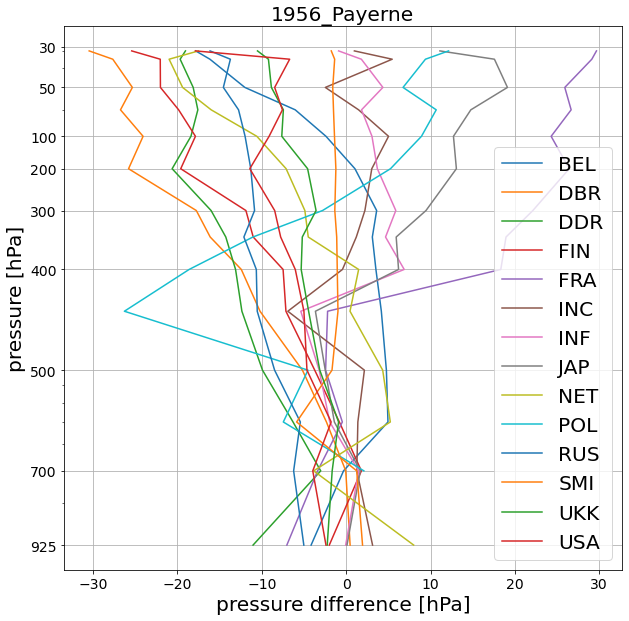

In [31]:
fig, (ax1) = plt.subplots(1)
yplevs = np.array([30,50,100,200,300,400,500,700,925])*100.
#     -
for i in range(len(means)):
    ax1.semilogy(newmeans[i]/100., pressure_list)
plt.rcParams.update({'font.size': 14})
ax1.set(xlabel ='pressure difference [hPa]', ylabel='pressure [hPa]', title=picname)
ax1.set_yticks(ticks=yplevs)
ax1.set_yticklabels(map("{:.0f}".format,np.flip(yplevs/100)),rotation='horizontal')
# ax1.set_ylim(90000,1000)
for i in range(len(st)):
    st[i]= str.upper(st[i][-3:])
ax1.legend(st, loc='best')
# ax1.invert_yaxis()
ax1.grid()
plt.savefig('Payerne_Font14.png')
plt.show()